# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
#altri import futuri

Caricamento del dataset

In [28]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset_bak = dataset
dataset.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


# Data Exploration

## Class Balancing

Siamo interessati a classificare i pazienti ricoverati come 'in pericolo di vita' oppure 'in salute'. Per questo motivo identifichiamo le due classi di interesse a partire dalla colonna ```hospital_death``` del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset.

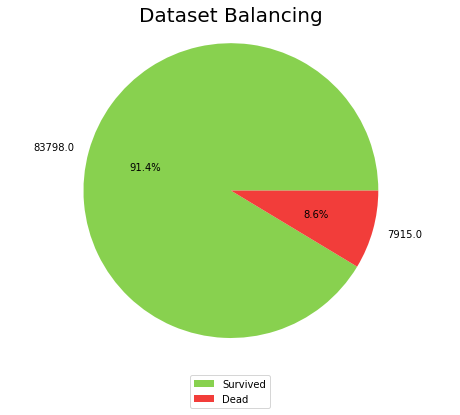

In [29]:
classes = [{"Survived": (dataset["hospital_death"] == 0).sum(), "Dead": (dataset["hospital_death"] == 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Come possiamo vedere il dataset è altamente sbilanciato. Infatti abbiamo il 91.4% di righe che riportano dati per un paziente sopravvissuto, mentre solo l'8.6% di dati per un paziente deceduto. Ciò implica dire che qualsiasi modello allenato su un training set ricavato da tale dataset tenderà maggiormente a classificare un'istanza come 'survived', aspettandoci quindi molti falsi negativi. (Positivo = death, Negativo = survived)

## Visualizzazione features

Andiamo a visualizzare la distribuzione delle features all'interno del dataset, riportando in un barplot le variabili categoriche e in un histplot le variabili numeriche.

encounter_id
patient_id
hospital_id
age
bmi
elective_surgery
ethnicity
gender
height
icu_admit_source
icu_id
icu_stay_type
icu_type
pre_icu_los_days
weight
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
heart_rate_apache
intubated_apache
map_apache
resprate_apache
temp_apache
ventilated_apache
d1_diasbp_max
d1_diasbp_min
d1_diasbp_noninvasive_max
d1_diasbp_noninvasive_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_mbp_noninvasive_max
d1_mbp_noninvasive_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_sysbp_noninvasive_max
d1_sysbp_noninvasive_min
d1_temp_max
d1_temp_min
h1_diasbp_max
h1_diasbp_min
h1_diasbp_noninvasive_max
h1_diasbp_noninvasive_min
h1_heartrate_max
h1_heartrate_min
h1_mbp_max
h1_mbp_min
h1_mbp_noninvasive_max
h1_mbp_noninvasive_min
h1_resprate_max
h1_resprate_min
h1_spo2_max
h1_spo2_min
h1_sysbp_max
h1_sysbp_min
h1_sysbp_

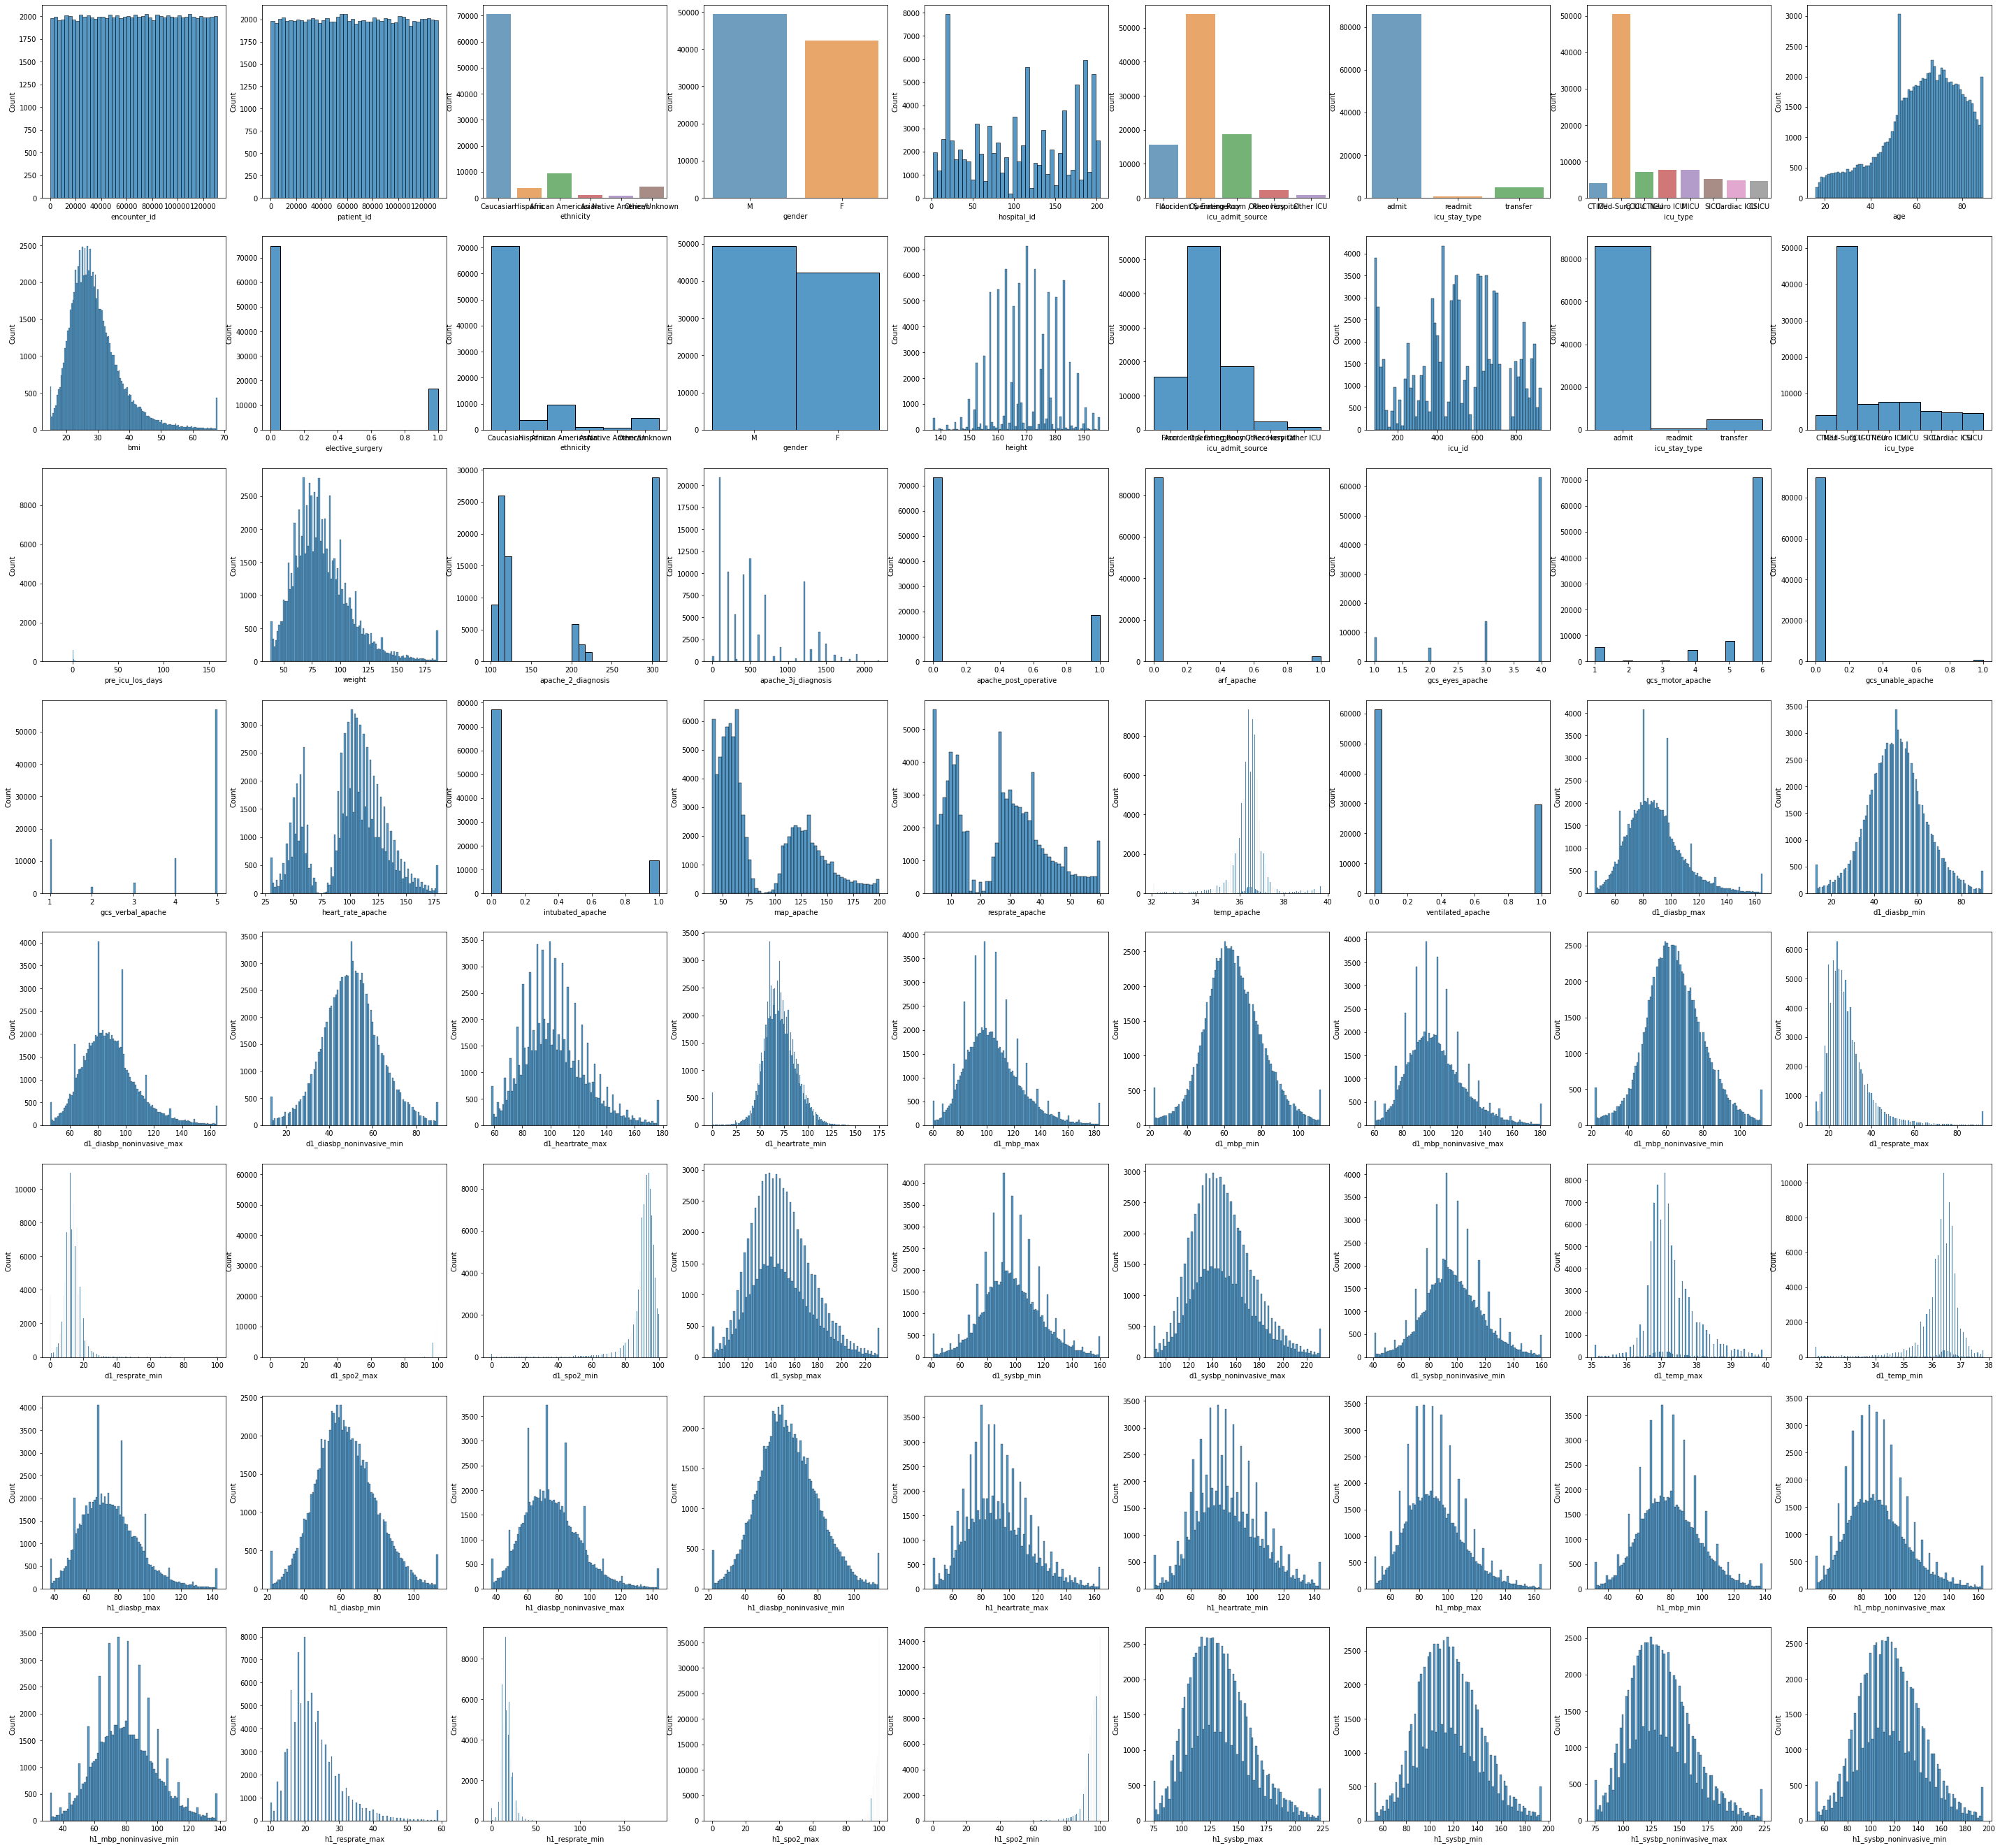

In [30]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
categ = []
categ_int = []
ordin = []

for col in dataset: 
    dt = dataset[col].dtype
    if dt == "object":
        categ.append(col)
    if dt == "float64":
        ordin.append(col)


fig = plt.figure(figsize=(50,60))

j=1
c=0
o=0
for i in range(0, len(categ) + len(ordin)):

    print(dataset.columns[i])
    if dataset.columns[i] in categ:
        fig.add_subplot(10,9,j)
        sns.countplot(x=categ[c], data=dataset, alpha=.7)
        j += 1
        c += 1

    elif dataset.columns[i] in ordin:
        fig.add_subplot(10,9,j)
        sns.histplot(dataset[dataset.columns[o]].dropna(), kde_kws={"lw": 2, "color":colors[8]})
        j += 1
        o += 1


In [31]:
print(c,j)
dataset.info()
print(categ)

5 73
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-

## Visualizzazione campi non nulli

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

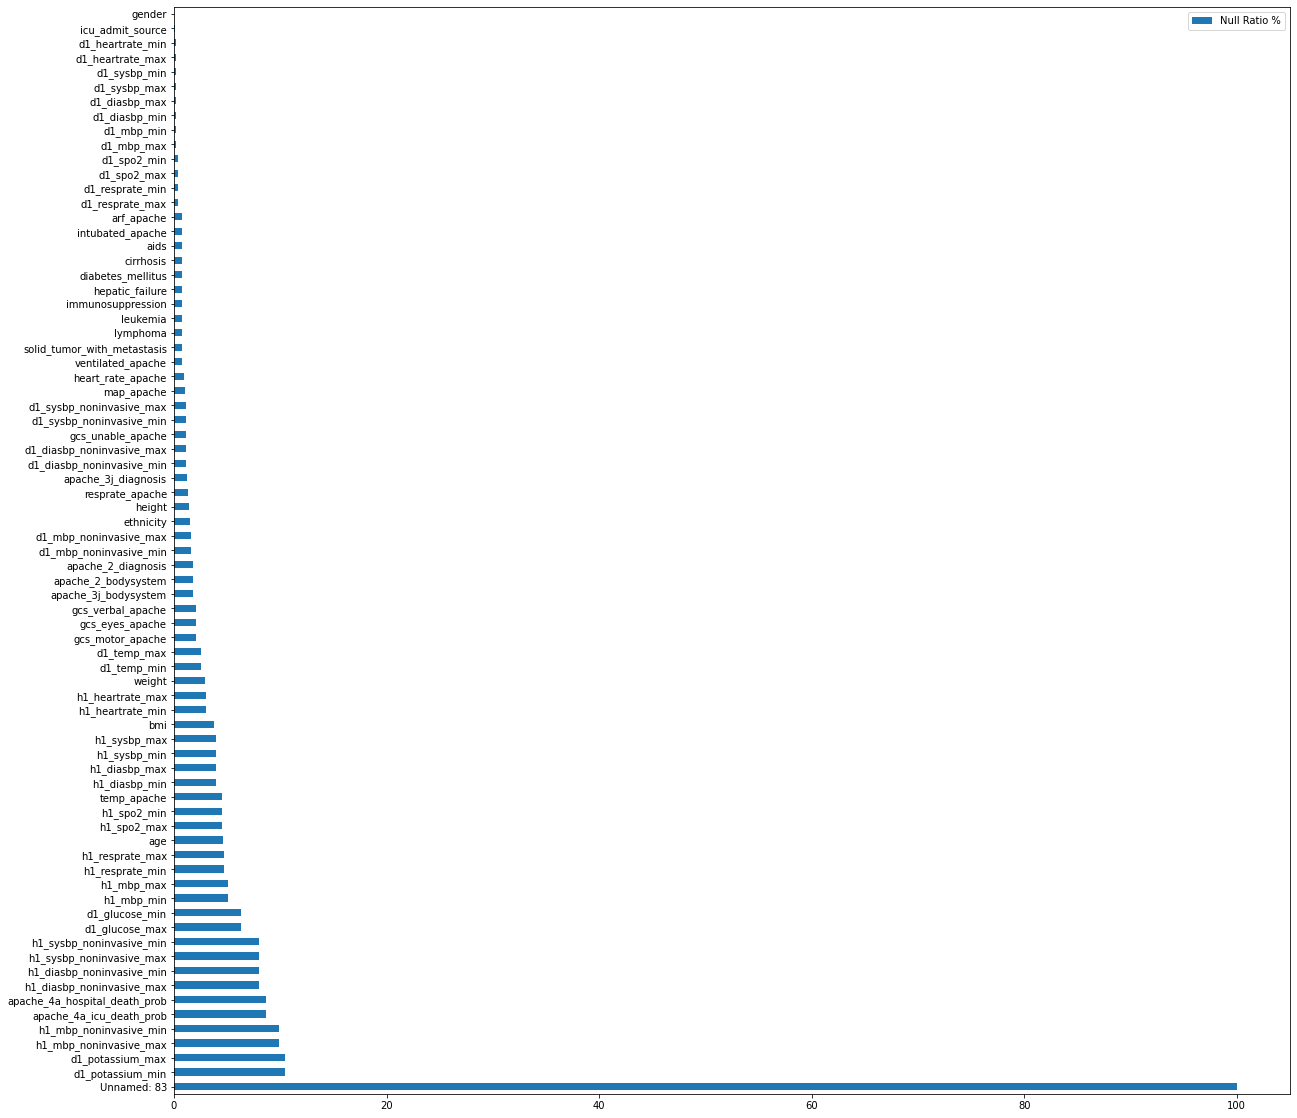

['Unnamed: 83']

In [32]:
def plot_nas(training_X: pd.DataFrame, threshold, use_treshold):
    to_delete = []
    if training_X.isnull().sum().sum() != 0:
        na_training_X = (training_X.isnull().sum() / len(training_X)) * 100
        na_training_X = na_training_X.drop(na_training_X[na_training_X == 0].index).sort_values(ascending=False)
        to_delete = na_training_X[na_training_X > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_training_X})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (20,20)

        if use_treshold:
            plt.axvline(x=50, color='red')
            plt.text(45,-1,'thr = 50', color = 'red')
        plt.show()
        
    else:
        print('No NAs found')
    return to_delete.index.tolist()
        

plot_nas(dataset,50,False)

Analizzando la distribuzione delle varie features possiamo vedere come il dataset sia di buona qualità, avendo pochi campi non nulli. Tuttavia la feature ```unnamed83``` presenta soltanto campi nulli, e quindi verrà eliminata in una successiva fase di pulizia del dataset.

Le restanti features presentano valori NaN per una percentuale sempre inferiore al 20%, motivo per cui possiamo procedere con una imputazione di tali dati, senza introdurre un rumore eccessivo nel dataset. 

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da ```object``` in ```category``` per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [33]:
mapped_dataset = dataset.copy()
encoder = LabelEncoder()
mapping = []

for i in range(len(mapped_dataset.columns)):
    
    if (mapped_dataset[mapped_dataset.columns[i]].dtype == "object"):
            mapped_dataset[mapped_dataset.columns[i]] = encoder.fit_transform(mapped_dataset[mapped_dataset.columns[i]])
            mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
            mapping.append(mapping_dict)

mapped_dataset = mapped_dataset.where(~dataset.isna(), dataset)
mapped_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  int32  
 12  icu_type                       91713 non-null 

Visualizziamo il mapping effettuato delle variabili categoriche.

- _NOTA_: I valori NaN risultano mappati nel dizionario, ma tramite la clausola ```where(~dataset.isna(), dataset)``` ristabiliamo i valori NaN originali per la successiva fase di imputazione dei dati.

In [34]:
print(mapping)

[{0: 'African American', 1: 'Asian', 2: 'Caucasian', 3: 'Hispanic', 4: 'Native American', 5: 'Other/Unknown', 6: nan}, {0: 'F', 1: 'M', 2: nan}, {0: 'Accident & Emergency', 1: 'Floor', 2: 'Operating Room / Recovery', 3: 'Other Hospital', 4: 'Other ICU', 5: nan}, {0: 'admit', 1: 'readmit', 2: 'transfer'}, {0: 'CCU-CTICU', 1: 'CSICU', 2: 'CTICU', 3: 'Cardiac ICU', 4: 'MICU', 5: 'Med-Surg ICU', 6: 'Neuro ICU', 7: 'SICU'}, {0: 'Cardiovascular', 1: 'Gastrointestinal', 2: 'Genitourinary', 3: 'Gynecological', 4: 'Hematological', 5: 'Metabolic', 6: 'Musculoskeletal/Skin', 7: 'Neurological', 8: 'Respiratory', 9: 'Sepsis', 10: 'Trauma', 11: nan}, {0: 'Cardiovascular', 1: 'Gastrointestinal', 2: 'Haematologic', 3: 'Metabolic', 4: 'Neurologic', 5: 'Renal/Genitourinary', 6: 'Respiratory', 7: 'Trauma', 8: 'Undefined Diagnoses', 9: 'Undefined diagnoses', 10: nan}]


Completiamo trasformando il tipo di dato associato alle features categoriche da ```object``` in ```float64```, oggetto che accetta valori interi nulli.

In [35]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [36]:
mapped_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  float64
 7   gender                         91688 non-null  float64
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  float64
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  int32  
 12  icu_type                       91713 non-null 

## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il paziente sopravvive o muore). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

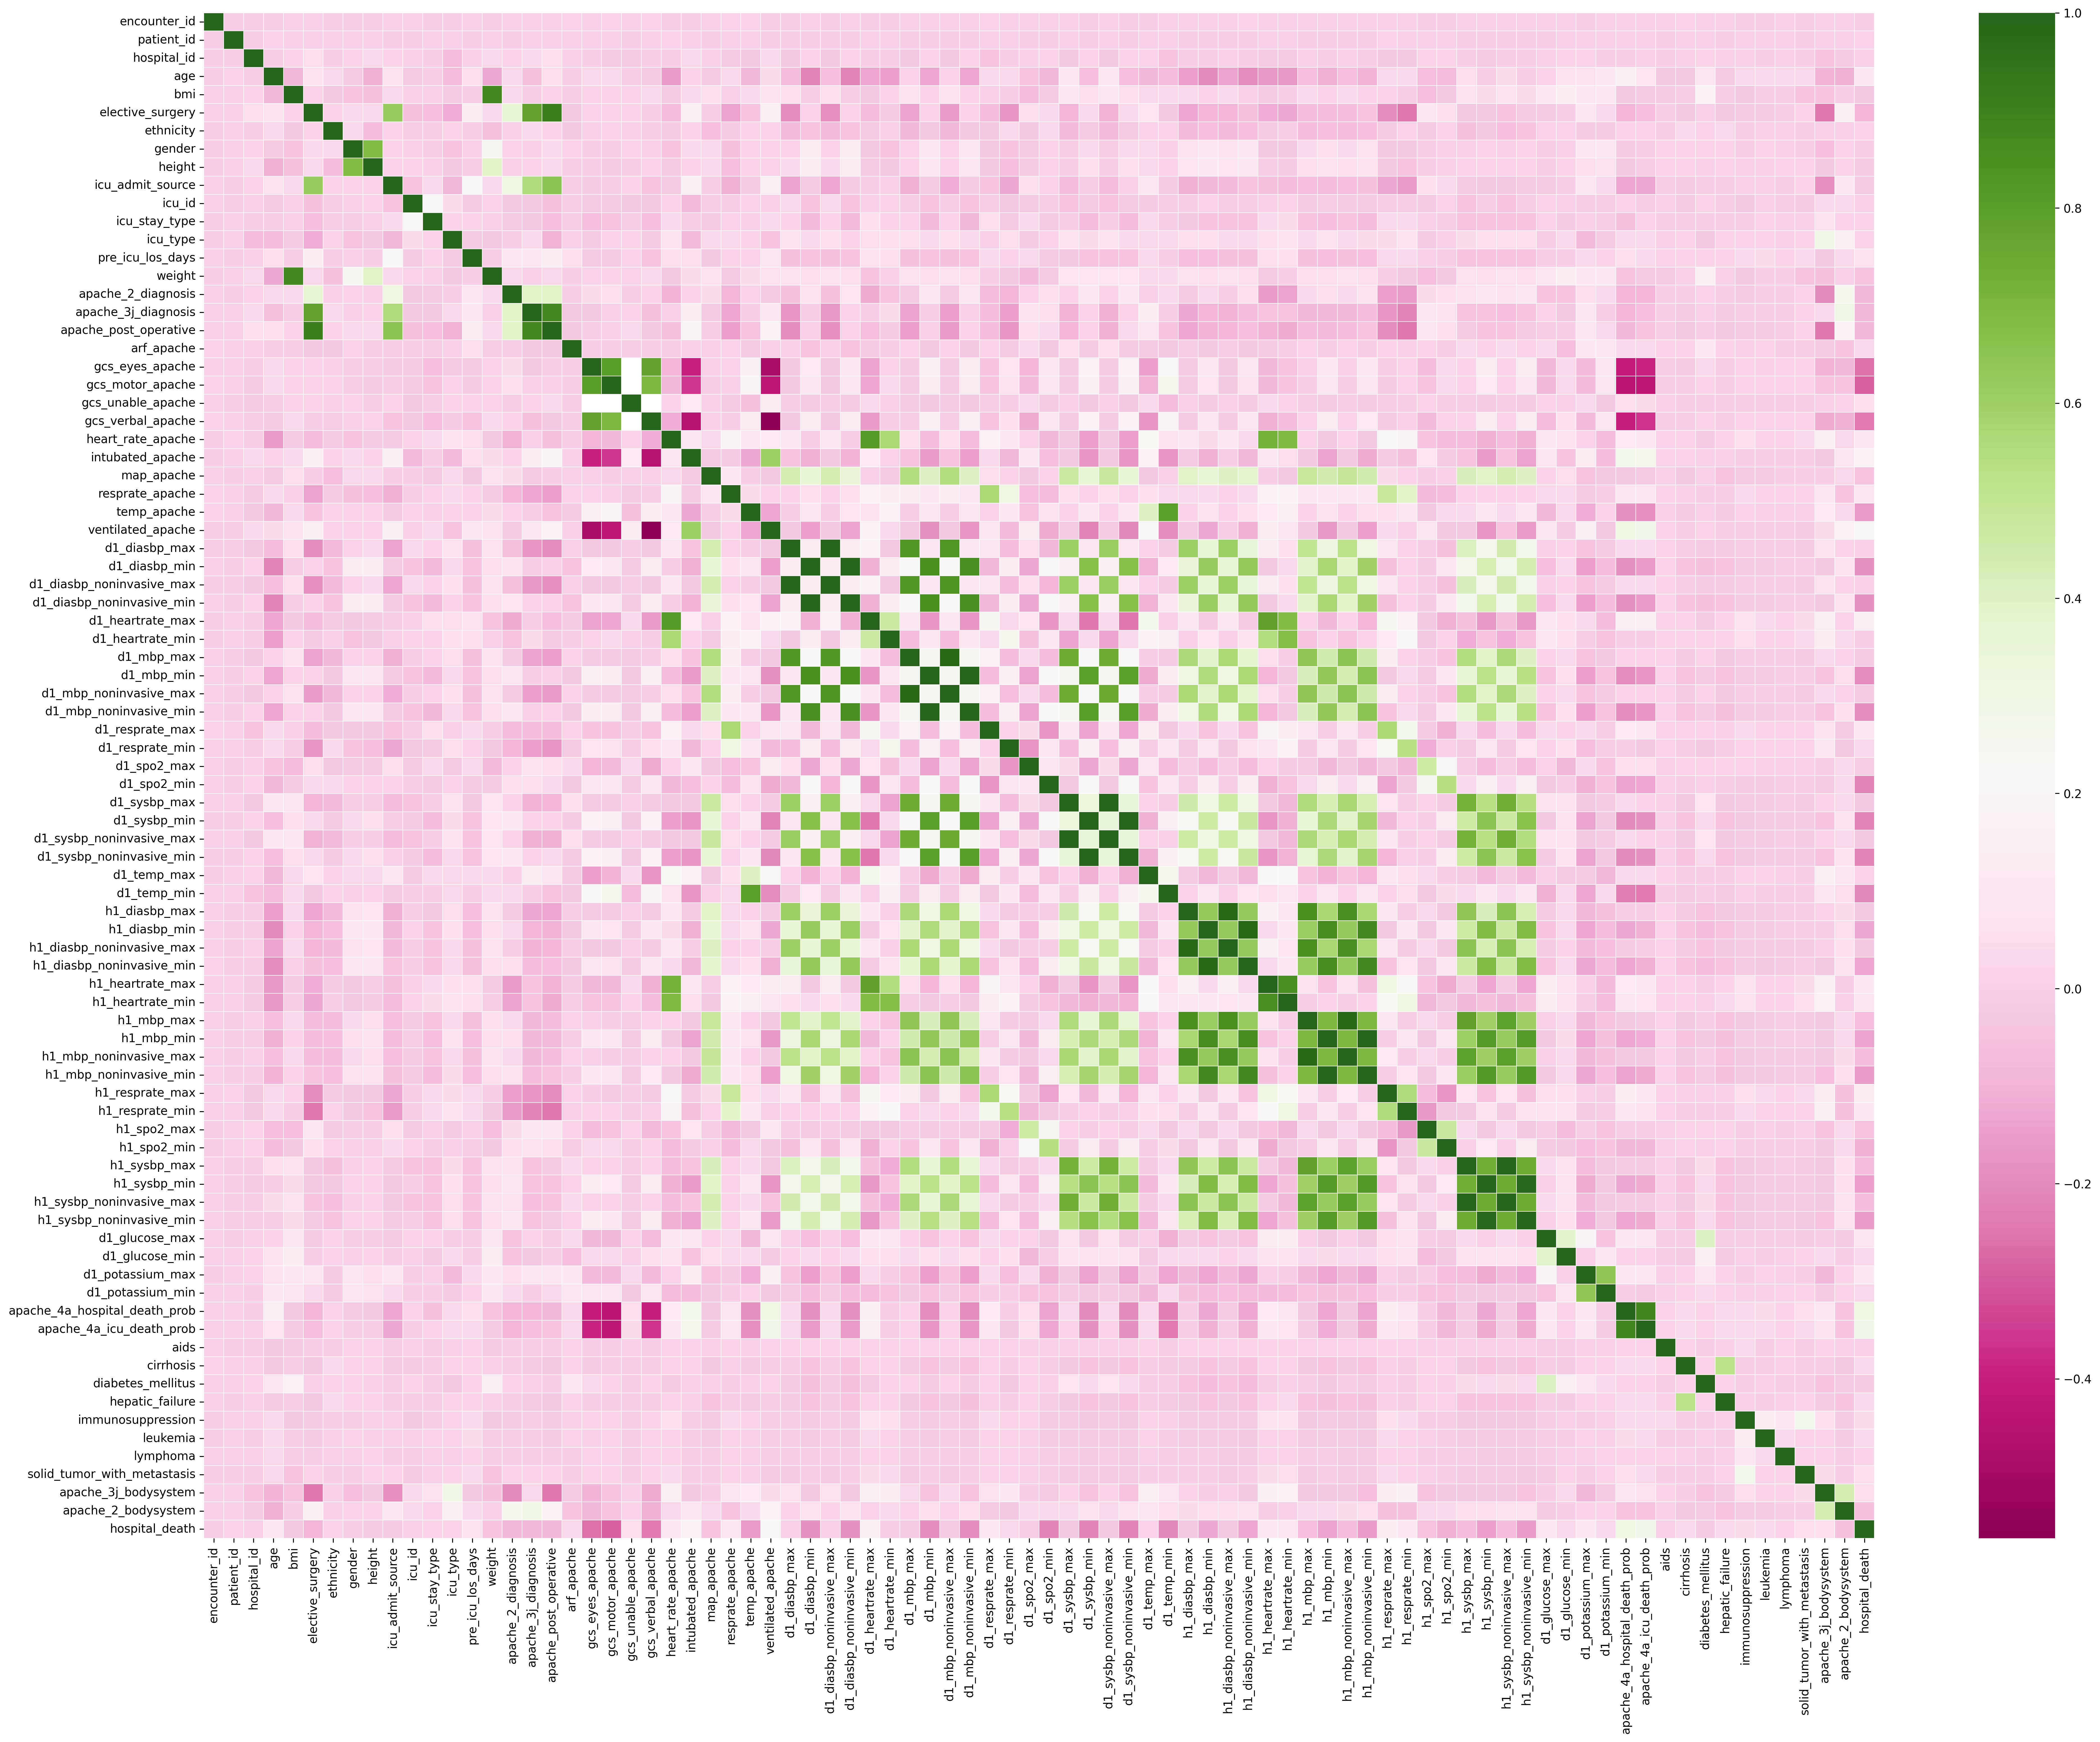

In [37]:
# Rimozione di unnamed83 dalla heatmap, avendo solo valori NaN
mapped_dataset = mapped_dataset.drop(columns = 'Unnamed: 83')

plt.figure(figsize=(32,24), dpi=300)
correlation_matrix = mapped_dataset.corr()
sns.heatmap(correlation_matrix, linewidths=0.05, cmap="PiYG")
plt.yticks(rotation=0)
plt.show()

# Training & Test Set Splitting

Andiamo a splittare il dataset in training e stesting set. Utilizziamo come percentuali 80/20

In [38]:
targets = mapped_dataset['hospital_death']
trainX, testX, trainY, testY = train_test_split(mapped_dataset.drop(columns = 'hospital_death'), targets, test_size = 0.2, random_state=0)
print("TrainingSet: {}".format(trainX.shape))
print("TestingSet: {}".format(testX.shape))

TrainingSet: (73370, 83)
TestingSet: (18343, 83)


# Results on Original Dataset

Andiamo a misurare le prestazioni di vari classificatori sul dataset originale, quindi senza ingegneria delle features e imputazione dei valori mancanti. 
- I classificatori considerati non gestiscono in modo automatico i valori ```NaN```
- Per eseguire la classificazione è comunque necessario mappare i valori ```NaN``` su un qualche valore numerico
- Si utilizza per questa fase di benchmark l'operatore ```fillna(-1)``` sostituendo quindi ```NaN``` con ```-1```

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# TODO questi poi vanno imputati, sono utili solo per sti score di base
trainX = trainX.fillna(-1)
trainY = trainY.fillna(-1)
testX = testX.fillna(-1)
lr = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo per 
rdt = DecisionTreeClassifier()
gnb = GaussianNB()

rdt.fit(trainX, trainY)
lr.fit(trainX, trainY)
gnb.fit(trainX, trainY)

# TODO altri classificatori in una lista e cose varie
lr_targets_predicted = lr.predict(testX)
rdt_targets_predicted = rdt.predict(testX)
gnb_targets_predicted = gnb.predict(testX)

print("Logistic Regression Classifier report: \n\n", classification_report(testY, lr_targets_predicted))
print("Decision Tree Classifier report: \n\n", classification_report(testY, rdt_targets_predicted))
print("Gaussian Naive Bayes Classifier report: \n\n", classification_report(testY, gnb_targets_predicted))


#cm = confusion_matrix(testY, lr_targets_predicted)
#x_axis_labels = ["Edible", "Poisonous"]
#y_axis_labels = ["Edible", "Poisonous"]
#f, ax = plt.subplots(figsize =(7,7))
#sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#plt.xlabel("PREDICTED LABEL")
#plt.ylabel("TRUE LABEL")
#plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.show()

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.99      0.95     16672
           1       0.68      0.12      0.21      1671

    accuracy                           0.91     18343
   macro avg       0.80      0.56      0.58     18343
weighted avg       0.90      0.91      0.89     18343

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93     16672
           1       0.33      0.35      0.34      1671

    accuracy                           0.88     18343
   macro avg       0.63      0.64      0.64     18343
weighted avg       0.88      0.88      0.88     18343

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.95      0.87      0.91     16672
           1       0.28      0.50      0.36      1671

    accuracy                           0.84     18343
   macr

# Training Set Cleaning

Andiamo ad eseguire diverse operazioni per rimuovere rumore dal dataset
- Rimozione feature nulle e con bassa varianza
- Feature Selection
- PCA
- Data Imputation

## Variance Threshold  
Procediamo con la rimozione delle feature che presentano una varianza minore del 20%.  
Vengono rimosse le feature:
- ``
  
TODO rivalutare dopo se variando la threshold le classificazioni migliorano 

In [40]:
old_columns = trainX.columns.copy()

selector = VarianceThreshold(0.2)
selector.fit(trainX)
selected_features = selector.get_feature_names_out()
trainX = trainX.loc[:, selector.get_support()]  

new_columns = [x for x in old_columns if x not in selected_features]
print("Features rimosse ", new_columns)

# for i in range(0, len(trainX)):
#     print("Variance of {} = {}".format(trainX.columns[i], results.variances_[i]))
trainX.info()

SyntaxError: invalid syntax (4245298749.py, line 8)

## Feature Selection

Prova con feature selection

In [ ]:
import statsmodels.api as sm

Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")
    
    
backward_regression(trainX.fillna(-1), trainY)

Prova con la feature selection a casaccio

In [ ]:
trainX_f = trainX_f.fillna(-1)
trainY = trainY.fillna(-1)
testX_f = testX_f.fillna(-1)
lr = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo per 
rdt = DecisionTreeClassifier()
gnb = GaussianNB()

rdt.fit(trainX_f, trainY)
lr.fit(trainX_f, trainY)
gnb.fit(trainX_f, trainY)

# TODO altri classificatori in una lista e cose varie
lr_targets_predicted = lr.predict(testX_f)
rdt_targets_predicted = rdt.predict(testX_f)
gnb_targets_predicted = gnb.predict(testX_f)

print("Logistic Regression Classifier report: \n\n", classification_report(testY, lr_targets_predicted))
print("Decision Tree Classifier report: \n\n", classification_report(testY, rdt_targets_predicted))
print("Gaussian Naive Bayes Classifier report: \n\n", classification_report(testY, gnb_targets_predicted))

# Classificazione
Sono stati analizzati i risultati ottenuti dai seguenti modelli:
* Naive Bayes
* 

Visualizziamo il balancing del training set

In [ ]:
classes = [{"Survived": (trainY== 0).sum(), "Dead": (trainY== 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Proviamo a bilanciare

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print (num_under)

rus = RandomOverSampler(random_state=0)
#trainX,trainY = rus.fit_resample(trainX.fillna(-1),trainY.fillna(-1))

Vediamo dai risultati che peggiorano tutte le metriche applicando il balancing.

In [ ]:
# TODO

Tiene solo le features selezionate

In [ ]:
trainX_f = trainX.loc[:, Selected_Features[0]]
testX_f = testX.loc[:, Selected_Features[0]]

trainX_f.shape

Vediamo i risultati base ottenuti dai classificatori considerati nel training set originale. Utilizzeremo questi per vedere se e come l'ingegneria delle features ed il cleaning del dataset permettono di migliorare la qualità del dataset e quindi del modello.